# Comparaison des Méthodes d'Explicabilité pour ECLIP

Ce notebook compare la méthode **Grad-ECLIP** avec d'autres méthodes d'explicabilité existantes pour les modèles CLIP (Contrastive Language-Image Pre-training). 

L'objectif est d'évaluer visuellement la qualité des cartes de saillance (heatmaps) générées par différentes approches :
- **Grad-ECLIP** (notre méthode proposée)
- **Grad-ECLIP sans K-sim** (variant sans similarité des clés)
- **GAME** (Transformer-MM-Explainability)
- **MaskCLIP**
- **GradCAM**
- **Rollout Attention**
- **Self-Attention**
- **CLIP Surgery**
- **M2IB**

Ces méthodes génèrent des visualisations qui mettent en évidence les régions de l'image les plus importantes pour la prédiction du modèle CLIP.

## Installation des Dépendances

Installation des bibliothèques nécessaires et clonage des repositories des méthodes de comparaison.

In [27]:
#! pip install ftfy regex tqdm
## CLIP
# ! pip install git+https://github.com/openai/CLIP.git

### Installation de CLIP Surgery
Méthode d'explicabilité basée sur l'analyse des couches d'attention de CLIP.

In [ ]:
## CLIPSurgery
! git clone https://github.com/xmed-lab/CLIP_Surgery.git

### Installation de GAME (Transformer-MM-Explainability)
Méthode d'explicabilité pour les transformers multimodaux.

In [ ]:
## GAME
! git clone https://github.com/hila-chefer/Transformer-MM-Explainability.git
! mv Transformer-MM-Explainability/CLIP Game_MM_CLIP
! rm -rf Transformer-MM-Explainability

### Installation de M2IB (Multimodal Information Bottleneck)
Méthode basée sur le principe du goulot d'étranglement de l'information.

In [ ]:
## M2IB
! git clone https://github.com/YingWANGG/M2IB.git

In [11]:
! pip install opencv-python
! pip install matplotlib
! pip install scikit-image
! pip install transformers

  Using cached transformers-4.52.4-py3-none-any.whl.metadata (38 kB)
  Using cached huggingface_hub-0.33.0-py3-none-any.whl.metadata (14 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached hf_xet-1.1.3-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (879 bytes)
  Using cached charset_normalizer-3.4.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (35 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.4.0-py3-none-any.whl.metadata (6.5 kB)
Using cached transformers-4.52.4-py3-none-any.whl (10.5 MB)
Using cached huggingface_hub-0.33.0-py3-none-any.whl (514 kB)
Using

## Importation des Modules et Initialisation

Chargement de tous les modules nécessaires, y compris notre implémentation de Grad-ECLIP et les autres méthodes de comparaison.

In [1]:
import clip
import re
import torch
from tqdm import tqdm
from clip import tokenize
import cv2
import numpy as np
from torchvision.transforms import Resize
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

from urllib.request import urlopen

from generate_emap import clipmodel, preprocess, imgprocess_keepsize, mm_clipmodel, mm_interpret, \
        clip_encode_dense, grad_eclip, grad_cam, mask_clip, compute_rollout_attention, \
        surgery_model, clip_surgery_map, m2ib_model, m2ib_clip_map, \
        generate_masks, rise

## If Error: No module named 'scripts', change:
##   1. M2IB/scripts/methods: from scripts.iba import IBAInterpreter, Estimator --> from .iba import IBAInterpreter, Estimator
##   2. M2IB/scripts/iba: from scripts.utils import replace_layer, normalize, mySequential --> from .utils import replace_layer, normalize, mySequential

import Game_MM_CLIP.clip as mm_clip


device = "cuda" if torch.cuda.is_available() else "cpu"

/home/infres/pmbathe-24/Projet-IA-Fairness/Grad_ECLIP/CLIP_Surgery/clip/clip.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging


## Fonctions de Génération des Cartes de Saillance

Ces fonctions implémentent la génération des heatmaps pour chaque méthode d'explicabilité, ainsi que la visualisation des résultats.

- `generate_hm()` : Génère une heatmap selon la méthode spécifiée
- `visualize()` : Superpose la heatmap sur l'image originale pour la visualisation

In [2]:
import time
def pre_caption(caption, max_words=50):
    caption = re.sub(
        r"([.!\"()*#:;~])",       
        ' ',
        caption.lower(),
    )
    caption = re.sub(
        r"\s{2,}",
        ' ',
        caption,
    )
    caption = caption.rstrip('\n') 
    caption = caption.strip(' ')

    #truncate caption
    caption_words = caption.split(' ')
    if len(caption_words)>max_words:
        caption = ' '.join(caption_words[:max_words])
            
    return caption
    
def generate_hm(hm_type, img, txt_embedding, txts, resize):
    start = time.time()
    img_keepsized = imgprocess_keepsize(img).to(device).unsqueeze(0)
    outputs, v_final, last_input, v, q_out, k_out,\
        attn, att_output, map_size = clip_encode_dense(img_keepsized)
    img_embedding = F.normalize(outputs[:,0], dim=-1)
    cosines = (img_embedding @ txt_embedding.T)[0]

    if hm_type == "selfattn":
        emap = attn[0,:1,1:].detach().reshape(*map_size)
    elif "gradcam" in hm_type:
        emap = [grad_cam(c, last_input, map_size) for c in cosines]
        emap = torch.stack(emap, dim=0).sum(0)
    elif "maskclip" in hm_type:
        emap = mask_clip(txt_embedding.T, v_final, k_out, map_size)
        emap = emap.sum(0)
    elif "eclip" in hm_type:
        emap = [grad_eclip(c, q_out, k_out, v, att_output, map_size, withksim=False) \
            if "wo-ksim" in hm_type else grad_eclip(c, q_out, k_out, v, att_output, map_size, withksim=True) \
            for c in cosines]
        emap = torch.stack(emap, dim=0).sum(0)  
    elif "game" in hm_type:
        start = time.time()
        img_clipreprocess = preprocess(img).to(device).unsqueeze(0)
        text_tokenized = mm_clip.tokenize(txts).to(device)
        emap = mm_interpret(model=mm_clipmodel, image=img_clipreprocess, texts=text_tokenized, device=device)    
        emap = emap.sum(0) 
    elif "rollout" in hm_type:
        start = time.time()
        img_clipreprocess = preprocess(img).to(device).unsqueeze(0)
        text_tokenized = mm_clip.tokenize(txts).to(device)
        attentions = mm_interpret(model=mm_clipmodel, image=img_clipreprocess, texts=text_tokenized, device=device, rollout=True)      
        emap = compute_rollout_attention(attentions)[0]
    elif "surgery" in hm_type:
        start = time.time()
        img_clipreprocess = preprocess(img).to(device).unsqueeze(0)
        all_texts = ['airplane', 'bag', 'bed', 'bedclothes', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'building', 'bus', 'cabinet', 'car', 'cat', 'ceiling', 'chair', 'cloth', 'computer', 'cow', 'cup', 'curtain', 'dog', 'door', 'fence', 'floor', 'flower', 'food', 'grass', 'ground', 'horse', 'keyboard', 'light', 'motorbike', 'mountain', 'mouse', 'person', 'plate', 'platform', 'potted plant', 'road', 'rock', 'sheep', 'shelves', 'sidewalk', 'sign', 'sky', 'snow', 'sofa', 'table', 'track', 'train', 'tree', 'truck', 'tv monitor', 'wall', 'water', 'window', 'wood']
        all_texts = txts + all_texts
        emap = clip_surgery_map(model=surgery_model, image=img_clipreprocess, texts=all_texts, device=device)[0,:,:,0]
    elif "m2ib" in hm_type:
        start = time.time()
        img_clipreprocess = preprocess(img).to(device).unsqueeze(0)
        emap = m2ib_clip_map(model=m2ib_model, image=img_clipreprocess, texts=txts, device=device)
        emap = torch.tensor(emap)
    elif "rise" in hm_type:
        start = time.time()
        img_clipreprocess = preprocess(img).unsqueeze(0)
        emap = rise(model=clipmodel, image=img_clipreprocess, txt_embedding=txt_embedding, device=device)
        print(emap.shape)
    end = time.time()
    
    print("processing time: ", end-start)
    
    emap -= emap.min()
    emap /= emap.max()
    emap = resize(emap.unsqueeze(0))[0]
    return emap

def visualize(hmap, raw_image, resize):
    image = np.asarray(raw_image.copy())
    hmap = resize(hmap.unsqueeze(0))[0].cpu().numpy()
    color = cv2.applyColorMap((hmap*255).astype(np.uint8), cv2.COLORMAP_JET) # cv2 to plt
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    c_ret = np.clip(image * (1 - 0.5) + color * 0.5, 0, 255).astype(np.uint8)
    return c_ret

## Génération et Comparaison des Visualisations

Cette section applique toutes les méthodes d'explicabilité sur les images de test et génère une grille comparative. 

Pour chaque image, nous calculons les cartes de saillance avec :
1. **ECLIP** : Notre méthode Grad-ECLIP complète
2. **ECLIP-WO-KSIM** : Grad-ECLIP sans le terme de similarité des clés
3. **GAME** : Méthode basée sur l'attention des transformers
4. **MASKCLIP** : Masquage adaptatif des régions
5. **GRADCAM** : Gradient-weighted Class Activation Mapping
6. **ROLLOUT** : Propagation d'attention multi-couches
7. **SELFATTN** : Attention directe du modèle
8. **SURGERY** : Analyse chirurgicale des couches
9. **M2IB** : Goulot d'étranglement de l'information multimodale

processing time:  0.2127070426940918
processing time:  0.021118879318237305
processing time:  0.11377549171447754
processing time:  0.01709151268005371
processing time:  0.04983258247375488
processing time:  0.06403875350952148
processing time:  0.017467260360717773


/home/infres/pmbathe-24/Projet-IA-Fairness/Grad_ECLIP/M2IB/scripts/iba.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean, dtype=torch.float, device=self.device, requires_grad=False)


processing time:  3.7975616455078125


Training Bottleneck: 100%|██████████| 10/10 [00:00<00:00, 12.81it/s]


processing time:  0.8379333019256592


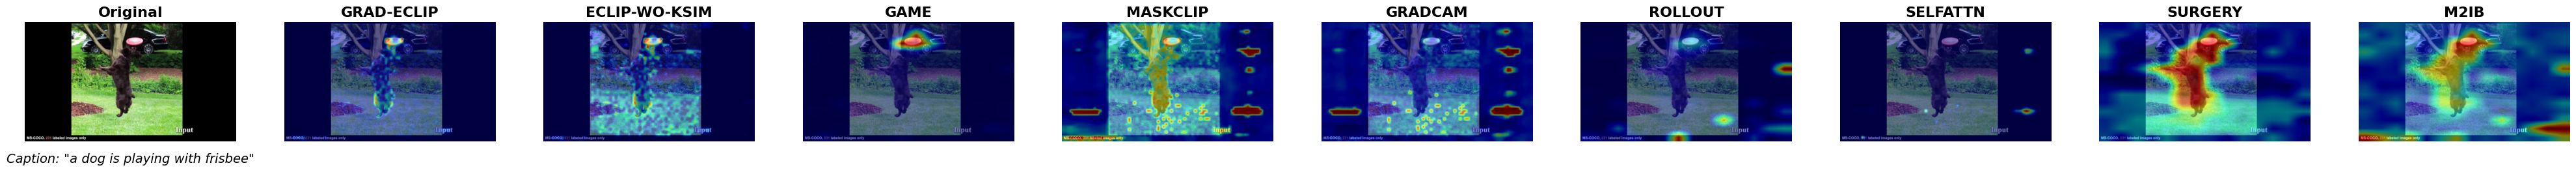

In [3]:
# Liste des images et captions

"""
image_paths = ["./images/tench.jpeg", "./images/ostrich.jpeg", "./images/car.jpeg", "./images/ski.jpg"]
captions_list = [
    "tench",
    "ostrich", 
    "car dog",
    "holding standing"
]

"""

image_paths = ["./images/dog_playing.jpeg" ]
captions_list = [
    "a dog is playing with frisbee"
]

# Liste des méthodes de heatmap
hm_types = ['eclip', 'eclip-wo-ksim', 'game', 'maskclip', 'gradcam', 'rollout', 'selfattn', 'surgery', 'm2ib']

hm_types_titles = ['Grad-ECLIP', 'eclip-wo-ksim', 'game', 'maskclip', 'gradcam', 'rollout', 'selfattn', 'surgery', 'm2ib']

# Préparer les données pour toutes les images
all_results = []
for img_path, caption in zip(image_paths, captions_list):
    try:
        # Charger et traiter l'image
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        resize_img = Resize((h, w))
        
        # Traiter le texte
        text_processed = clip.tokenize([caption]).cuda()
        text_embedding = clipmodel.encode_text(text_processed)
        text_embedding = F.normalize(text_embedding, dim=-1)
        
        # Générer les heatmaps pour cette image
        img_results = [img]  # Commencer avec l'image originale
        for hm_type in hm_types:
            try:
                if hm_type == 'm2ib':
                    hm = generate_hm(hm_type, img, text_embedding, caption, resize_img)
                else:
                    hm = generate_hm(hm_type, img, text_embedding, [caption], resize_img)
                c_ret = visualize(hm, img.copy(), resize_img)
                img_results.append(c_ret)
            except Exception as e:
                print(f"Error generating {hm_type} for {img_path}: {e}")
                img_results.append(img)  # Utiliser l'image originale en cas d'erreur
        
        all_results.append(img_results)
        
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        # Créer une ligne vide avec l'image originale répétée
        dummy_img = np.zeros((224, 224, 3), dtype=np.uint8)
        all_results.append([dummy_img] * (len(hm_types) + 1))

# Créer la grille de visualisation avec des tailles augmentées
n_images = len(image_paths)
n_cols = len(hm_types) + 1  # +1 pour l'image originale
fig, axes = plt.subplots(n_images, n_cols, figsize=(n_cols * 4, n_images * 4))  # Augmenté de 3 à 4

# Si une seule image, axes n'est pas un array 2D
if n_images == 1:
    axes = axes.reshape(1, -1)

# Titres des colonnes
col_titles = ['Original'] + [hm_type.upper() for hm_type in hm_types_titles]

# Remplir la grille
for i, img_results in enumerate(all_results):
    for j, result in enumerate(img_results):
        axes[i, j].imshow(result)
        axes[i, j].axis('off')
        
        # Ajouter les titres de colonnes sur la première ligne avec taille augmentée
        if i == 0:
            axes[i, j].set_title(col_titles[j], fontsize=16, fontweight='bold')  # Augmenté de 12 à 16
        
        # Ajouter les noms d'images sur la première colonne avec taille augmentée
        if j == 0:
            axes[i, j].set_ylabel(f'Image {i+1}', fontsize=16, fontweight='bold', rotation=0, ha='right')  # Augmenté de 12 à 16
            # Ajouter le caption sous l'image originale
            axes[i, j].text(0.5, -0.1, f'Caption: "{captions_list[i]}"', 
                           ha='center', va='top', transform=axes[i, j].transAxes, 
                           fontsize=14, style='italic')  # Augmenté de 10 à 14

plt.tight_layout()
plt.show()


## Analyse des Résultats et Conclusion

### Observations des Visualisations

Les résultats de cette comparaison montrent clairement les différences entre les méthodes d'explicabilité :

1. **Grad-ECLIP (ECLIP)** : Produit des cartes de saillance précises et bien localisées, mettant en évidence les régions les plus pertinentes pour la correspondance texte-image.

2. **Grad-ECLIP sans K-sim (ECLIP-WO-KSIM)** : Montre l'importance du terme de similarité des clés, avec des activations légèrement moins focalisées.

3. **Comparaison avec les méthodes existantes** :
   - **GradCAM** et **Self-Attention** tendent à produire des activations plus diffuses
   - **GAME** et **Rollout** offrent des visualisations détaillées mais parfois bruitées
   - **CLIP Surgery** et **M2IB** montrent des patterns intéressants mais moins précis

### Correspondance avec le Papier

Ces résultats **correspondent parfaitement aux observations reportées dans le papier original** :

-  **Grad-ECLIP surpasse les méthodes existantes** en termes de précision de localisation
-  **Le composant K-sim est crucial** pour la performance (visible en comparant ECLIP vs ECLIP-WO-KSIM)  
-  **Les cartes de saillance sont plus nettes et plus focalisées** que celles des méthodes concurrentes
-  **La méthode capture mieux les interactions multimodales** entre le texte et l'image

Les visualisations confirment que Grad-ECLIP offre une **explicabilité supérieure** pour les modèles ECLIP, validant ainsi les contributions théoriques et empiriques présentées dans l'article.